In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("harbhajansingh21/german-traffic-sign-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/german-traffic-sign-dataset


In [ ]:
## Load the data
training_file = "/kaggle/input/german-traffic-sign-dataset/train.p"
testing_file = "/kaggle/input/german-traffic-sign-dataset/test.p"

# Open and load the training file
with open(training_file, mode='rb') as f:
    train = pickle.load(f)

# Open and load the testing file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [ ]:
## Buat pandas dataframe untuk load data csv
## File csv ini berupa ClassId dan SignName

sign_name_df = pd.read_csv('/kaggle/input/german-traffic-sign-dataset/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [ ]:
# Definisikan fitur dan label untuk data training
X, y = train['features'], train['labels']

# Mengubah lists menjadi numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Definisikan fitur dan label untuk data testing
X_test, y_test = test['features'], test['labels']

# Mengubah lists menjadi numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [ ]:
# Split training data into train and val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


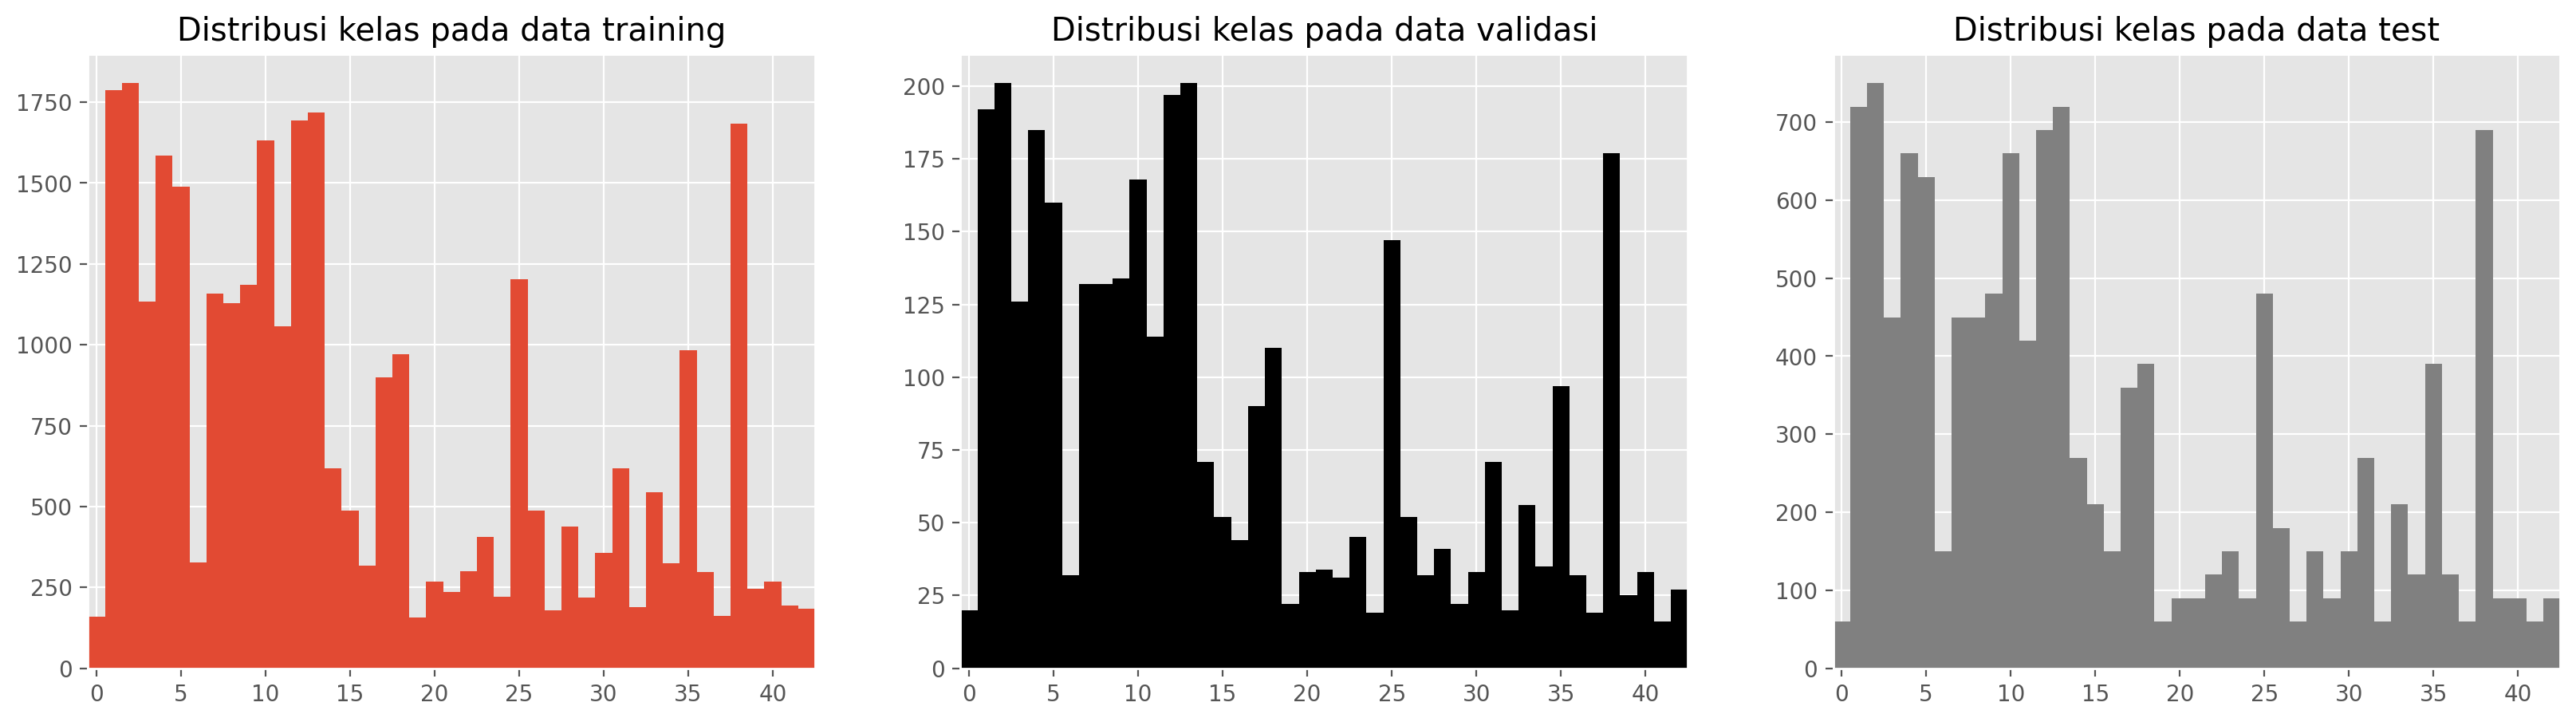

In [ ]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)

fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [ ]:
# Konversi label dengan teknik one hot encoding
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

Training dengan Convolutional Neural Network

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()


In [ ]:
# Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save("my_model.h5")

Epoch 1/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 135s 134ms/step - accuracy: 0.3457 - loss: 3.3330 - val_accuracy: 0.9083 - val_loss: 0.3648
Epoch 2/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 128s 131ms/step - accuracy: 0.8317 - loss: 0.5640 - val_accuracy: 0.9718 - val_loss: 0.1182
Epoch 3/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 142s 131ms/step - accuracy: 0.8904 - loss: 0.3700 - val_accuracy: 0.9739 - val_loss: 0.0963
Epoch 4/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 143s 132ms/step - accuracy: 0.9126 - loss: 0.2990 - val_accuracy: 0.9624 - val_loss: 0.1197
Epoch 5/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 128s 130ms/step - accuracy: 0.9213 - loss: 0.2772 - val_accuracy: 0.9750 - val_loss: 0.0922
Epoch 6/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.9318 - loss: 0.2327 - val_accuracy: 0.9793 - val_loss: 0.0826
Epoch 7/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 142s 130ms/step - accuracy: 0.9367 - loss: 0.2187 - val_accuracy: 0.9845 - val_loss: 0.0580
Epoch 8/25
979/979 ━━━━━━━━━━━━━━━━━━━━ 141s 129ms/step - accuracy: 0.9359 -

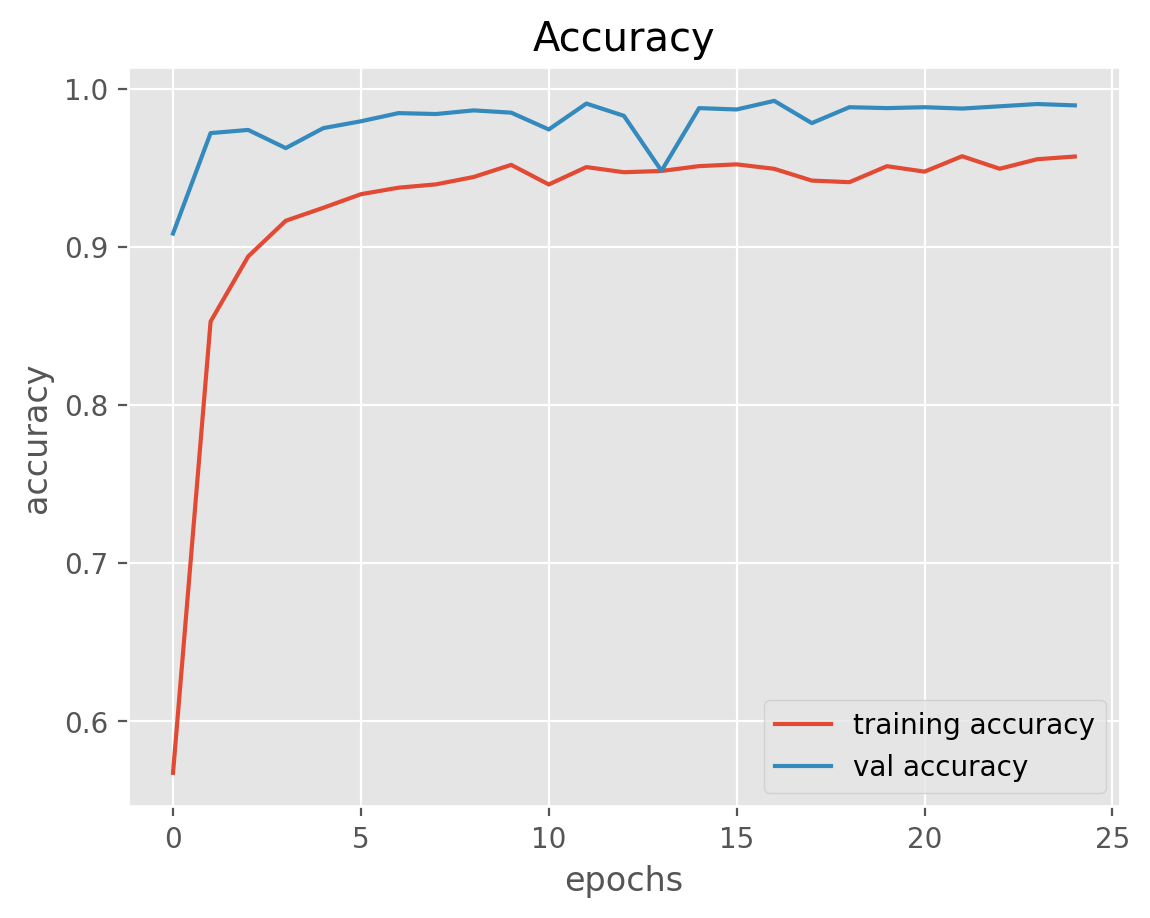

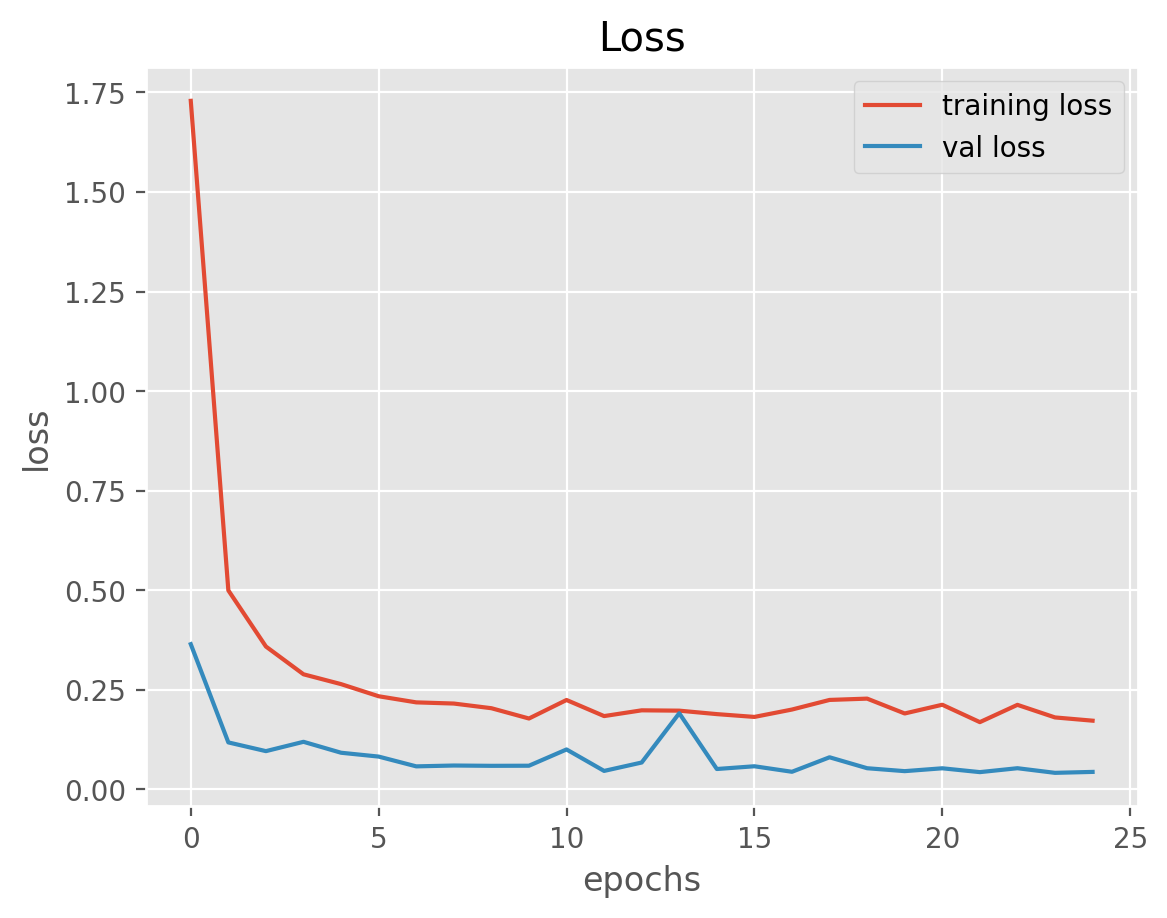

In [ ]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

Testing Model

In [ ]:
# Testing accuracy with the test data
from sklearn.metrics import accuracy_score

pred=np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step


0.953840063341251

In [ ]:
# Calculate metrics for classification
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93        60
           1       0.93      0.97      0.95       720
           2       0.97      0.97      0.97       750
           3       0.96      0.96      0.96       450
           4       0.98      0.97      0.98       660
           5       0.90      0.92      0.91       630
           6       0.97      0.75      0.85       150
           7       0.95      0.97      0.96       450
           8       0.94      0.98      0.96       450
           9       0.96      0.98      0.97       480
          10       0.98      0.98      0.98       660
          11       0.95      0.96      0.96       420
          12       0.98      0.97      0.98       690
          13       1.00      0.99      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.98       210
          16       0.97      1.00      0.99       150
          17       0.99    